Markowitz Efficient Frontier Portoflio Optimizer



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_datareader import data as pdr
from datetime import datetime
import yfinance as yfin
import requests
import scipy.optimize as sco
import scipy.interpolate as sci

In [2]:
#Set Up
port = pd.read_excel('Port.xlsx', parse_dates =[15])
port = port.rename(columns=port.loc[8])
port = port.drop(np.arange(0,12)).reset_index(drop=True)
port = port[port['Position'].notna()].reset_index(drop=True)
cols = []
count = 1
for column in port.columns:
    if column == 'Price':
        cols.append(f'Price_{count}')
        count+=1
        continue
    cols.append(column)
port.columns = cols
port = port.sort_values('ID').reset_index(drop = True)
port
#note that Price_1 is the current price as of the Bloomberg pull, and Price_2 is the Price we bought at

,Security,PK,ID,Position,Price_1,PCS,FX Rate,Principal,Accrued,Market Val,Price_2,FX Rate,Principal,Accrued,Cost Val,Cost Date
0,AMRC US,AMRC US Equity,AMRC,140,55.1,EXCH,1,7714,NaN,7714,55,1,7700,NaN,7700,12/22/22
1,DAR US,DAR US Equity,DAR,175,66.85,EXCH,1,11698.75,NaN,11698.75,67.31,1,11779.57,NaN,11779.57,11/29/22
2,ETR US,ETR US Equity,ETR,140,105.76,EXCH,1,14803.6,NaN,14803.6,103.93,1,14550.2,NaN,14550.2,02/13/23
3,GPP US,GPP US Equity,GPP,1200,13.05,EXCH,1,15660,NaN,15660,12.27,1,14726.86,NaN,14726.86,11/23/22
4,ICLN US,ICLN US Equity,ICLN,870,19.87,EXCH,1,17286.9,NaN,17286.9,17.84,1,15520.45,NaN,15520.45,10/13/22
5,MVST US,MVST US Equity,MVST,1000,1.53,EXCH,1,1530,NaN,1530,1.96,1,1957.7,NaN,1957.7,12/09/22
6,STEM US,STEM US Equity,STEM,350,9.15,EXCH,1,3202.5,NaN,3202.5,10.55,1,3690.75,NaN,3690.75,12/09/22


In [3]:
port_assets = list(port['ID'])
#port_assets = ['GPP', 'MVST', 'STEM','AMRC','ICLN','DAR','ETR','UTWO']
test_assets = ['AAPL', 'TSLA', 'AMZN', 'GOOGL']
low_cor_assets = ['AMRC','GPP']
#port_assets = test_assets
#port_assets = low_cor_assets
#Define the start date as the day you want
start_date = "2010-01-01"
#end date is today. Can be changed for serial analysis
today = datetime.today().strftime('%Y-%m-%d')
tradingdays = 253
port_assets

['AMRC', 'DAR', 'ETR', 'GPP', 'ICLN', 'MVST', 'STEM']

OPTIMIZER

In [4]:
#Data Frame
#key = '4M3P116F6VI43U85'
#df = TimeSeries(key, output_format='pandas')
#df = df.get_daily_adjusted('ARRY')
#df = data.DataReader(port_assets, 'iex', start = start_date, end = today)
yfin.pdr_override()
df = pdr.get_data_yahoo(port_assets,start = start_date, end = today)
df = df['Adj Close'].dropna()
df.head()



[*********************100%***********************]  7 of 7 completed


,AMRC,DAR,ETR,GPP,ICLN,MVST,STEM
Date,,,,,,,
2020-10-08,36.830002,40.540001,97.739784,6.132502,20.619560,10.210,9.700
2020-10-09,37.779999,42.349998,96.499916,6.116696,20.942501,10.200,9.760
2020-10-12,38.020000,43.380001,96.818993,6.092988,20.511906,10.200,9.700
2020-10-13,38.299999,43.540001,97.074249,6.164112,20.443405,10.170,9.750
2020-10-14,38.669998,43.279999,96.417847,6.322166,20.688057,10.175,9.762


In [5]:
#Covariance Matrix

cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,AMRC,DAR,ETR,GPP,ICLN,MVST,STEM
AMRC,0.001621,0.000431,0.000105,0.000089,0.000633,0.000801,0.001275
DAR,0.000431,0.000738,0.000087,0.000159,0.000259,0.000320,0.000574
ETR,0.000105,0.000087,0.000209,0.000034,0.000056,0.000035,0.000013
GPP,0.000089,0.000159,0.000034,0.000390,0.000087,0.000072,0.000228
ICLN,0.000633,0.000259,0.000056,0.000087,0.000451,0.000422,0.000723
MVST,0.000801,0.000320,0.000035,0.000072,0.000422,0.003632,0.001153
STEM,0.001275,0.000574,0.000013,0.000228,0.000723,0.001153,0.003942


In [6]:
#Correlation Matrix

corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,AMRC,DAR,ETR,GPP,ICLN,MVST,STEM
AMRC,1.000000,0.394376,0.180652,0.112251,0.739986,0.330064,0.504371
DAR,0.394376,1.000000,0.222605,0.296640,0.448899,0.195596,0.336271
ETR,0.180652,0.222605,1.000000,0.120036,0.182178,0.040016,0.013801
GPP,0.112251,0.296640,0.120036,1.000000,0.208325,0.060389,0.184153
ICLN,0.739986,0.448899,0.182178,0.208325,1.000000,0.329896,0.542329
MVST,0.330064,0.195596,0.040016,0.060389,0.329896,1.000000,0.304599
STEM,0.504371,0.336271,0.013801,0.184153,0.542329,0.304599,1.000000


In [7]:
#Expected Returns
    #Here, it is calculated based off past yearly returns. Can be switched out for own expected returns (CAPM, Fama French etc)
    #annual in our model
ind_er = df.resample('Y').last().pct_change().mean()                    #the 'Y' is for yearly samples.

#Volatility
    #expressed as annual . Multiplied by root 250 for yearly

ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(tradingdays))

assets = pd.concat([ind_er,ann_sd], axis = 1)
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
AMRC,0.056233,0.640372
DAR,0.047697,0.432063
ETR,0.057654,0.230154
GPP,0.317275,0.314127
ICLN,-0.107784,0.337837
MVST,-0.501088,0.958623
STEM,-0.229974,0.998716


In [8]:
#Returns and Volatility Function Creation
    #these functions are called later in the optimization step as inputs for the func arg.

def portfolio_returns(weights):
    return np.sum(ind_er * weights)

def portfolio_sd(weights):
    return np.sqrt(np.transpose(weights) @ (cov_matrix * tradingdays) @ weights)*np.sqrt(tradingdays)

In [9]:
#Frontier Creation
    #the efficient frontier will be simulated using random weights for the individual assets. Might be a way to solve for weights? A lot more math lol

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights
num_assets = len(port_assets)
num_portfolios = 10

for portfolio in range(num_portfolios):
    weights = np.random.random(size = num_assets)
    weights = weights / np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis = 0).mul(weights, axis = 1).sum().sum()       #portfolio variance. taken by the weights of each asset multiplied acros the covariance matrix
    sd = np.sqrt(var)      #daily standard deviation
    ann_sd = sd*np.sqrt(tradingdays)
    p_vol.append(ann_sd)

data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol + ' Weight'] = [w[counter] for w in p_weights]

portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,AMRC Weight,DAR Weight,ETR Weight,GPP Weight,ICLN Weight,MVST Weight,STEM Weight
0,0.023171,0.289039,0.148965,0.202477,0.219340,0.157656,0.153800,0.051161,0.066602
1,0.026546,0.317622,0.244601,0.221142,0.179938,0.156081,0.081509,0.081228,0.035500
2,-0.125842,0.427709,0.010242,0.146472,0.303057,0.017374,0.066496,0.163296,0.293062
3,-0.141760,0.462224,0.180523,0.063964,0.196828,0.014652,0.105456,0.216631,0.221945
4,-0.087483,0.399231,0.158436,0.046226,0.077056,0.210947,0.189439,0.281956,0.035941


In [10]:
#Lowest Risk Portfolio

min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.
min_vol_port

Returns        0.023171
Volatility     0.289039
AMRC Weight    0.148965
DAR Weight     0.202477
ETR Weight     0.219340
GPP Weight     0.157656
ICLN Weight    0.153800
MVST Weight    0.051161
STEM Weight    0.066602
Name: 0, dtype: float64

Optimal Risky Portfolio
Sharpe Ratio: -0.003692415001375525
Returns        0.026546
Volatility     5.052089
AMRC Weight    0.244601
DAR Weight     0.221142
ETR Weight     0.179938
GPP Weight     0.156081
ICLN Weight    0.081509
MVST Weight    0.081228
STEM Weight    0.035500
Name: 1, dtype: float64


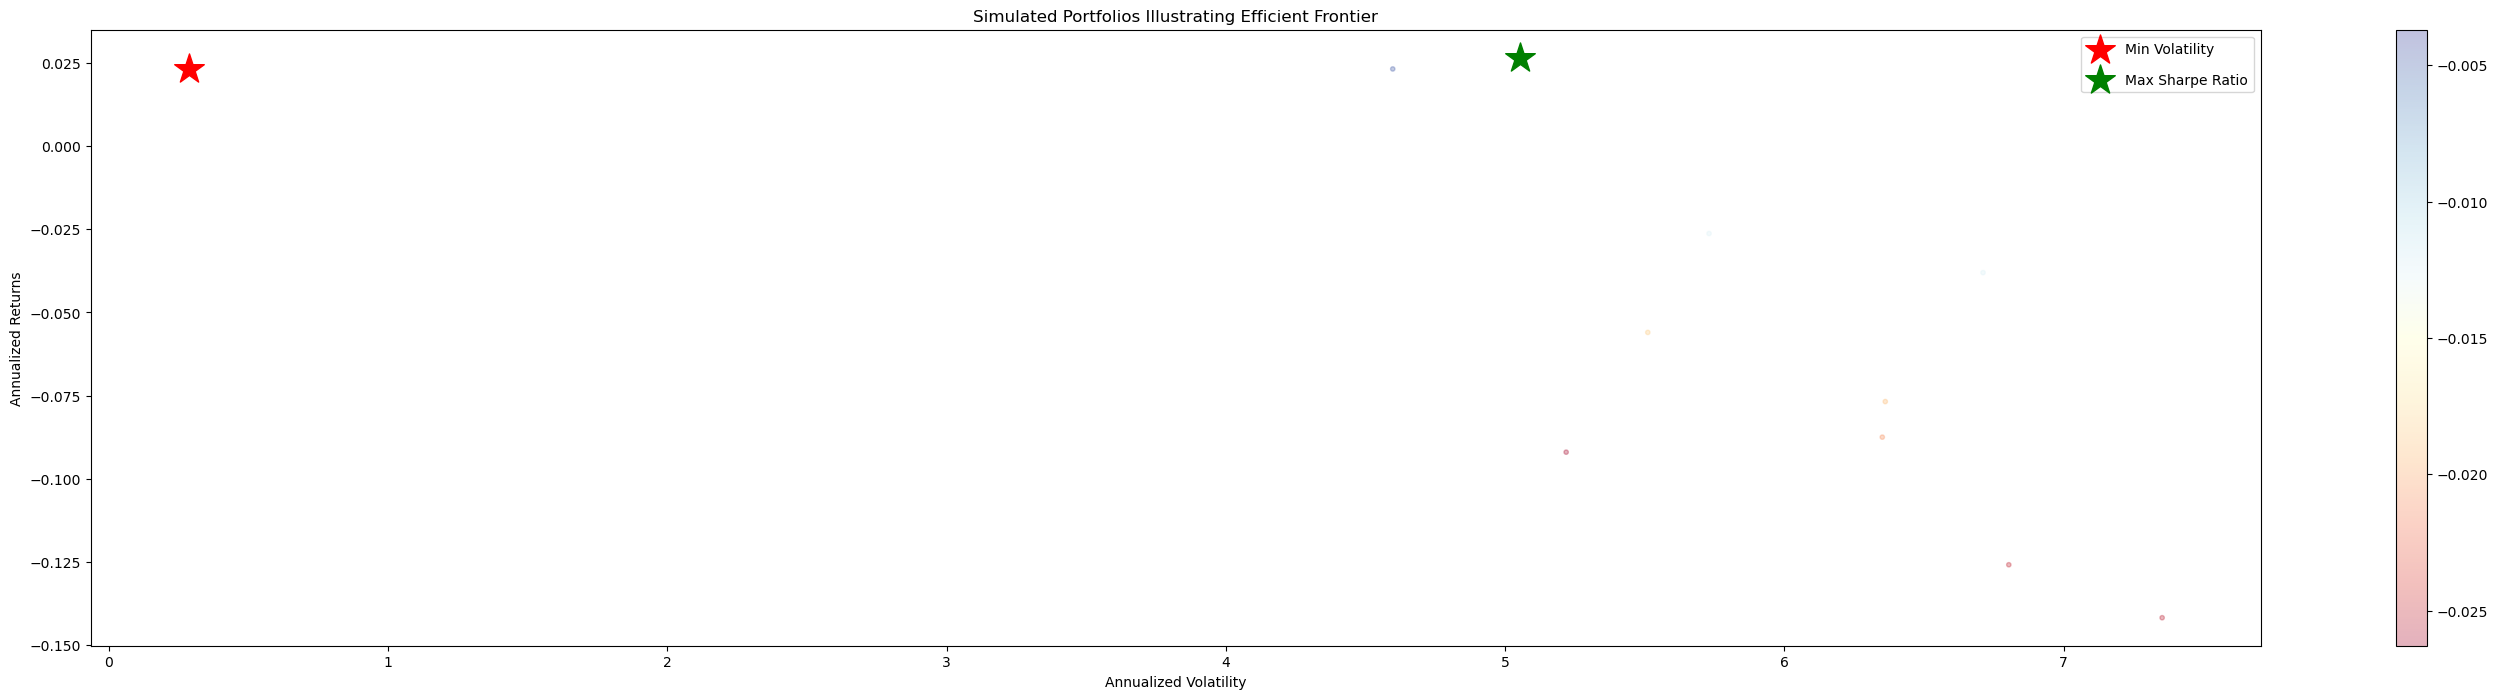

In [11]:
#Optimal Risk Portfolio (Sharpe not Draw Downs)

rf = 0.0452 # risk free rate
portfolios['Volatility'] = portfolios['Volatility']*np.sqrt(tradingdays)
risky_ports=(portfolios['Returns']-rf)/portfolios['Volatility']
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]

plt.style.use('seaborn-pastel')
plt.subplots(figsize=(35, 8))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],c=risky_ports, cmap='RdYlBu',marker='o', s=10, alpha=0.3, facecolor = 'w')
plt.colorbar()
plt.title('Simulated Portfolios Illustrating Efficient Frontier')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Returns')
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500, label='Min Volatility')
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500 , label='Max Sharpe Ratio')
plt.legend(labelspacing = 1.2)
print('Optimal Risky Portfolio')
max_sharpe=max(((portfolios['Returns']-rf)/portfolios['Volatility']))
print("Sharpe Ratio:",max_sharpe)
print(optimal_risky_port)


In [12]:
#this is the user defined Sharpe ratio function
def sharpe_fun(weights):
    return - ((portfolio_returns(weights) - rf) / portfolio_sd(weights))

constraints = [{'type':'eq','fun': lambda x: np.sum(x) - 1},
               {'type':'ineq','fun': lambda x: x-0.05 }]                #using an anonymous lambda function

#creats 12 tuples of (0,1), all of which exist in a container tuple -> basically a sequence of (min, max) pairs.

bounds = tuple(
    (0,1) for w in weights
)

# Repeat the list with the value (1 / 12) 12 times, and convert list to array
equal_weights = np.array(
    [1 / len(port_assets)] * len(port_assets)
)

len(port_assets)

7

In [13]:
#Convex Optimization

# Minimization (really maximize) Sharpe
max_sharpe_results = sco.minimize(
    # Objective function
    fun = sharpe_fun,
    # Initial guess, which is the equal weight array
    x0 = equal_weights,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

# Minimize sd
min_sd_results = sco.minimize(
    # Objective function
    fun = portfolio_sd,
    # Initial guess, which is the equal weight array
    x0 = equal_weights,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

In [14]:
#calculated outputs
max_sharpe_port_return = portfolio_returns(max_sharpe_results["x"])
print('Max Sharpe Port Return', round(max_sharpe_port_return, 4))

max_sharpe_port_sd = portfolio_sd(max_sharpe_results["x"])
print('Max Sharpe Port SD', round(max_sharpe_port_sd, 4))

max_sharpe_port_sharpe = (max_sharpe_port_return - rf) / max_sharpe_port_sd
print('Max Sharpe Port Sharpe Ratio', round(max_sharpe_port_sharpe, 4))

print('===============================================================')

min_sd_port_return = portfolio_returns(min_sd_results["x"])
print('Min SD Port Return', round(min_sd_port_return, 4))

min_sd_port_sd = portfolio_sd(min_sd_results["x"])
print('Min SD Port SD', round(min_sd_port_sd, 4))

max_sharpe_port_sharpe = (min_sd_port_return - rf) / min_sd_port_sd
print('Min SD Port Sharpe Ratio', round(max_sharpe_port_sharpe, 4))

max_sharpe_results["x"]

Max Sharpe Port Return 0.1882
Max Sharpe Port SD 4.3744
Max Sharpe Port Sharpe Ratio 0.0327
Min SD Port Return 0.0624
Min SD Port SD 3.34
Min SD Port Sharpe Ratio 0.0051


array([0.05, 0.05, 0.05, 0.7 , 0.05, 0.05, 0.05])

Current Portfolio Metrics

In [15]:
current_port_pos = port['Position'].reindex().mul(df.iloc[-1].transpose().reset_index(drop = True))
current_port_weight = np.array(current_port_pos / current_port_pos.sum())
current_port_sd = portfolio_sd(current_port_weight)
current_port_ret = portfolio_returns(current_port_weight)
current_port_sharp = (current_port_ret - rf) / current_port_sd
print('Current Portfolio Return:', current_port_ret)
print('Current Portfolio Standard Deviation:', current_port_sd)
print('Current Portfolio Variance:', current_port_sd**2)
print('Current Portfolio Sharpe Ratio:', current_port_sharp)


Current Portfolio Return: 0.05041361470081289
Current Portfolio Standard Deviation: 4.066433159909706
Current Portfolio Variance: 16.535878644013234
Current Portfolio Sharpe Ratio: 0.0012821100202046994


SyntaxError: unexpected character after line continuation character (1402009641.py, line 1)